### CNN with Image Augmentation (CIFAR10)
images of 10 categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck. In RGB, 32x32 pixels. The state of the art accuracy is 96.53 percent.


In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as k
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
import h5py
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.examples.tutorials.mnist import input_data
# from keras.preprocessing.image import ImageDataGenerator

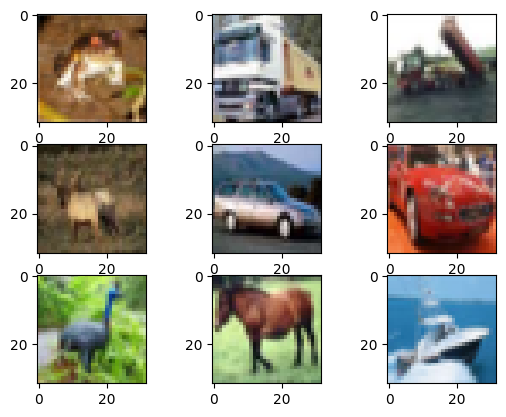

In [9]:
#load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_rows, img_cols , channels= 32,32,3
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

In [10]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=1,
    zoom_range=0.2
    )
datagen.fit(x_train)

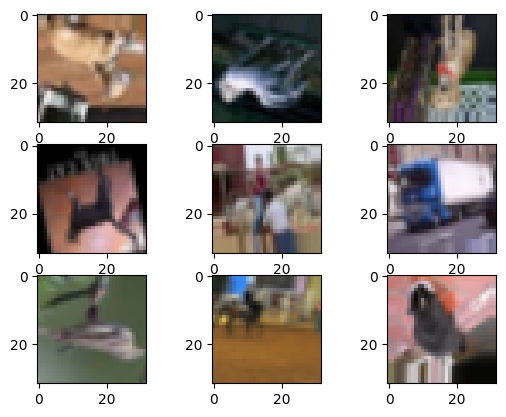

In [11]:
# see example augmentation images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break



In [12]:
#reshape into images
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, 1)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


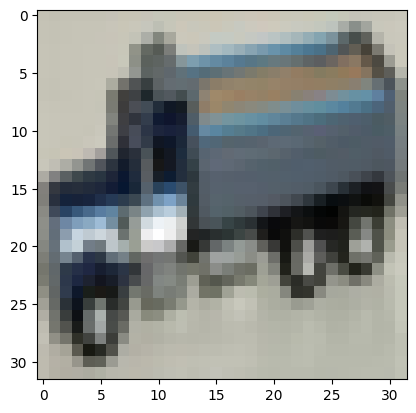

In [13]:
plt.imshow(x_train[340])

In [14]:
#convert integers to float; normalise and center the mean
x_train=x_train.astype("float32")
x_test=x_test.astype("float32")
mean=np.mean(x_train)
std=np.std(x_train)
x_test=(x_test-mean)/std
x_train=(x_train-mean)/std

In [15]:
# labels
num_classes=10
y_train = k.utils.to_categorical(y_train, num_classes)
y_test = k.utils.to_categorical(y_test, num_classes)

In [16]:
# plotting helper function
def plothist(hist):
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [17]:
# build and compile the model  (roughly following the VGG paper)

# reg=l2(1e-4)   # L2 or "ridge" regularisation
reg=None
num_filters=32
ac='relu'
adm=Adam(learning_rate=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

model = Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels),padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac,kernel_regularizer=reg,padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac,kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
# training without augmentation
history=model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test, y_test))

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.4167 - loss: 1.9048 - val_accuracy: 0.5687 - val_loss: 1.1968
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.6698 - loss: 0.9491 - val_accuracy: 0.7021 - val_loss: 0.8702
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7544 - loss: 0.7057 - val_accuracy: 0.7486 - val_loss: 0.7415
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8020 - loss: 0.5639 - val_accuracy: 0.7631 - val_loss: 0.6897
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8399 - loss: 0.4617 - val_accuracy: 0.7704 - val_loss: 0.6708
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.8689 - loss: 0.3793 - val_accuracy: 0.7728 - val_loss: 0.7009
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8917 - loss: 0.3103 - val_accuracy: 0.7814 - val_loss: 0.6969
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9120 - loss: 0.2536 - val_a

In [20]:
#training accuracy without dropout
train_acc=model.evaluate(x_train,y_train,batch_size=128)
train_acc

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9845 - loss: 0.0460


[0.04676448181271553, 0.9840599894523621]

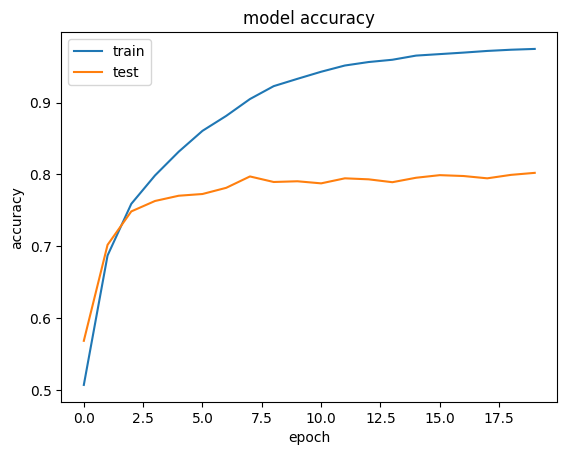

In [21]:
plt.plot(history.history['accuracy']) # Changed 'acc' to 'accuracy'
plt.plot(history.history['val_accuracy']) # Changed 'val_acc' to 'val_accuracy'
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.save('cifar10_01.h5')
model=load_model('cifar10_01.h5')

In [23]:
# build again, same model as model1

#reg=l2(1e-4)   # L2 or "ridge" regularisation
reg2=None
num_filters2=32
ac2='relu'
adm2=Adam(learning_rate=0.001,decay=0, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt2=adm2
drop_dense2=0.5
drop_conv2=0

model2 = Sequential()

model2.add(Conv2D(num_filters2, (3, 3), activation=ac2, kernel_regularizer=reg2, input_shape=(img_rows, img_cols, channels),padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 16x16x3xnum_filters
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(2*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 8x8x3x(2*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(Conv2D(4*num_filters2, (3, 3), activation=ac2,kernel_regularizer=reg2,padding='same'))
model2.add(BatchNormalization(axis=-1))
model2.add(MaxPooling2D(pool_size=(2, 2)))   # reduces to 4x4x3x(4*num_filters)
model2.add(Dropout(drop_conv2))

model2.add(Flatten())
model2.add(Dense(512, activation=ac2,kernel_regularizer=reg2))
model2.add(BatchNormalization())
model2.add(Dropout(drop_dense2))
model2.add(Dense(num_classes, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt2)

In [24]:
# Calculate steps_per_epoch to ensure an integer value
steps_per_epoch = len(x_train) // 128  # Use floor division (//) for integer result

history2 = model2.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=(x_test, y_test),
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


390/390 ━━━━━━━━━━━━━━━━━━━━ 46s 96ms/step - accuracy: 0.3255 - loss: 2.2293 - val_accuracy: 0.4787 - val_loss: 1.3958
Epoch 2/30
  1/390 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3906 - loss: 1.7158

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3906 - loss: 1.7158 - val_accuracy: 0.4807 - val_loss: 1.3923
Epoch 3/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 71s 81ms/step - accuracy: 0.4929 - loss: 1.4276 - val_accuracy: 0.5413 - val_loss: 1.3081
Epoch 4/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5547 - loss: 1.2925 - val_accuracy: 0.5362 - val_loss: 1.3237
Epoch 5/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 32s 81ms/step - accuracy: 0.5622 - loss: 1.2134 - val_accuracy: 0.6065 - val_loss: 1.1816
Epoch 6/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6406 - loss: 1.0840 - val_accuracy: 0.6118 - val_loss: 1.1434
Epoch 7/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 84ms/step - accuracy: 0.6099 - loss: 1.0829 - val_accuracy: 0.6448 - val_loss: 1.0258
Epoch 8/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6953 - loss: 1.0174 - val_accuracy: 0.6399 - val_loss: 1.0436
Epoch 9/30
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.6492 - loss: 0.9855 - val_accuracy: 0.690

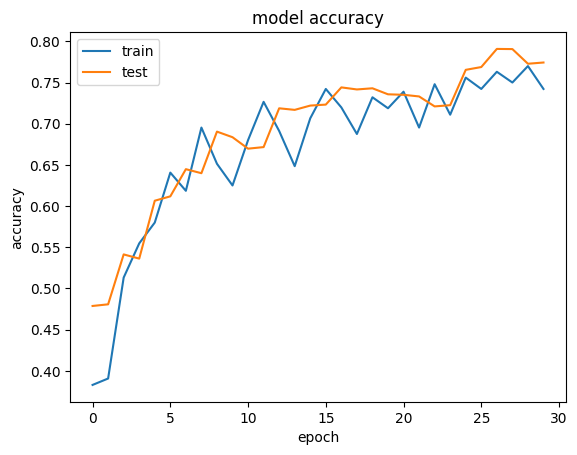

In [25]:
plt.plot(history2.history['accuracy']) # Changed 'acc' to 'accuracy'
plt.plot(history2.history['val_accuracy']) # Changed 'val_acc' to 'val_accuracy'
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model2_test_acc=model2.evaluate(x_test,y_test,batch_size=128)
model2_test_acc

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7743 - loss: 0.7227


[0.7183080315589905, 0.7684000134468079]

In [ ]:
model2_train_acc=model2.evaluate(x_train,y_train,batch_size=128)
model2_train_acc

391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7981 - loss: 0.6081


[0.614565372467041, 0.794439971446991]